In [139]:
%load_ext autoreload
%autoreload 2
import sklearn
from sklearn.datasets import load_wine, load_iris
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler

from einops import rearrange
import numpy as np
import matplotlib.pyplot as plt

from convexlocalisometry.transformation import exponential_transformation
from convexlocalisometry.loss import isometry_loss
from convexlocalisometry.algorithm import greedy, brute, group_basis_pursuit, group_lasso
import random

np.random.seed(1234)
random.seed(1234)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [168]:
# vary C show results
wine = load_wine()
P_wine, D_wine = wine['data'].shape
print(f"D_wine = {D_wine}")
print(f"features = {wine['feature_names']}")
print(f"P_wine = {P_wine}")

wine_df = pd.DataFrame(data= wine['data'], columns = wine['feature_names']) # label with class names?
scaler = StandardScaler()
wine_standardized = pd.DataFrame(data = scaler.fit_transform(wine['data']), columns = wine['feature_names'])

iris = load_iris()
P_iris, D_iris = iris['data'].shape

print("D_iris", D_iris)
print(f"features = {iris['feature_names']}")
print("P_iris", P_iris)
iris_df = pd.DataFrame(data= iris['data'], columns = iris['feature_names'])

scaler = StandardScaler()
iris_standardized = pd.DataFrame(data = scaler.fit_transform(iris['data']), columns = iris['feature_names'])

D_wine = 13
features = ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
P_wine = 178
D_iris 4
features = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
P_iris 150


In [175]:
print("these are standarized to square root P")
print(np.linalg.norm(iris_standardized, axis = 0))
print(np.linalg.norm(wine_standardized, axis = 0))

these are standarized to square root P
[12.24744871 12.24744871 12.24744871 12.24744871]
[13.34166406 13.34166406 13.34166406 13.34166406 13.34166406 13.34166406
 13.34166406 13.34166406 13.34166406 13.34166406 13.34166406 13.34166406
 13.34166406]


In [169]:
# must do experiment for group lasso norm versus algorithm is it contained

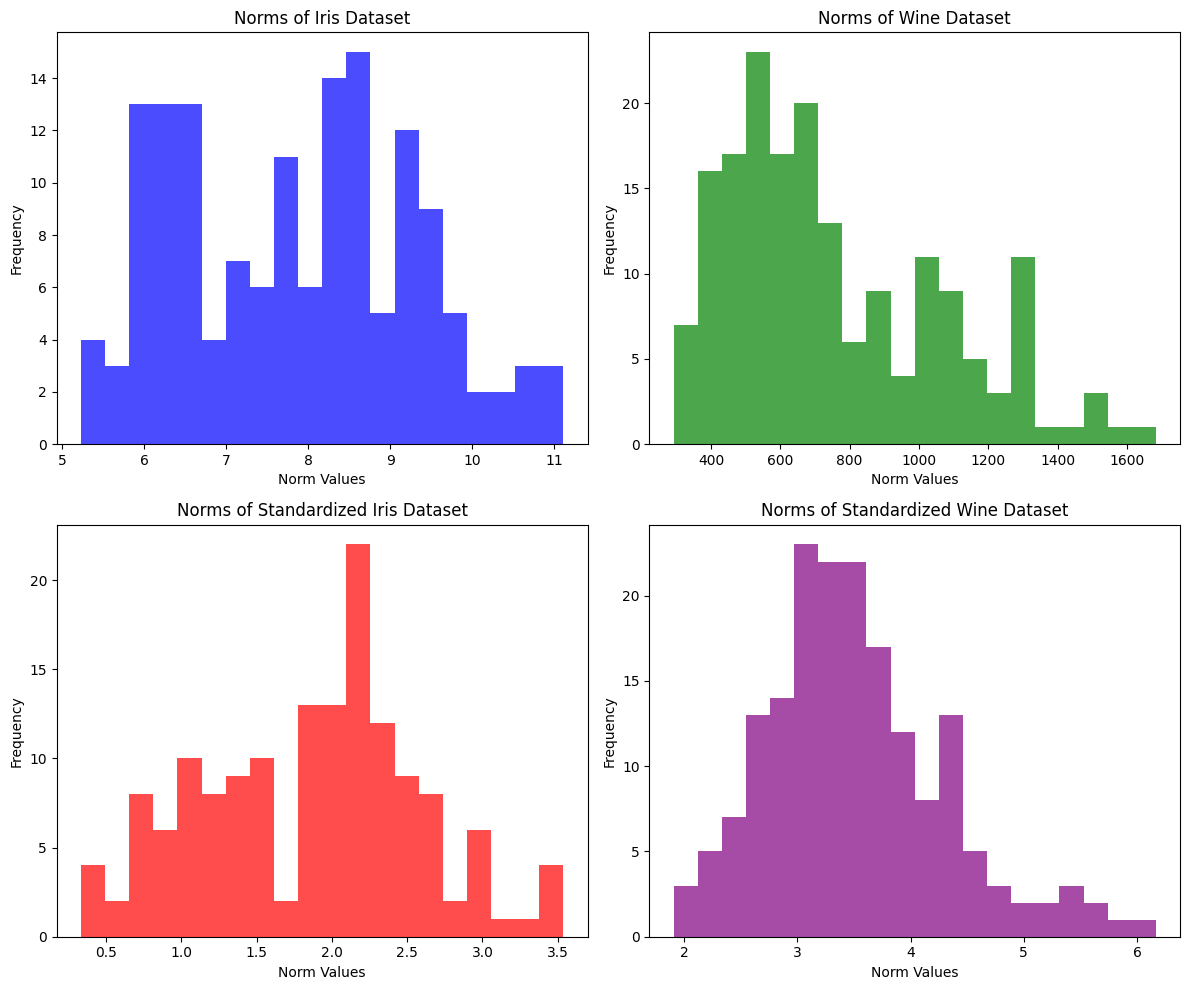

In [176]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot for Iris dataset
axs[0, 0].hist(np.linalg.norm(iris_df, axis=1), bins=20, alpha=0.7, color='blue')
axs[0, 0].set_title("Norms of Iris Dataset")

# Plot for Wine dataset
axs[0, 1].hist(np.linalg.norm(wine_df, axis=1), bins=20, alpha=0.7, color='green')
axs[0, 1].set_title("Norms of Wine Dataset")

# Plot for Standardized Iris dataset
axs[1, 0].hist(np.linalg.norm(iris_standardized, axis=1), bins=20, alpha=0.7, color='red')
axs[1, 0].set_title("Norms of Standardized Iris Dataset")

# Plot for Standardized Wine dataset
axs[1, 1].hist(np.linalg.norm(wine_standardized, axis=1), bins=20, alpha=0.7, color='purple')
axs[1, 1].set_title("Norms of Standardized Wine Dataset")

# Adding overall labels and adjusting layout
for ax in axs.flat:
    ax.set_xlabel('Norm Values')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [283]:
power = 1.
isometry_loss_power = lambda x : isometry_loss(x, power)
group_brute_loss = lambda x : group_lasso_norm(np.linalg.inv(x))

In [467]:
def run_experiment(data, D, frac = .5, R = 25, compute_brute = False):
    print("Analyzing data")
    losses = []
    support_cardinalities_basis_pursuit = []
    two_stage_losses = []
    random_two_stage_losses= []
    greedy_multitask_norms = []
    greedy_multitask_norms_two_stage = []
    brute_isometry_losses = []
    brute_losses = []

    for i in range(R):
        np.random.seed(i)
        X = data.sample(frac = frac).to_numpy().transpose() # .5
        print("Data subsampled dimension", X.shape)
        output = greedy(X, isometry_loss_power, D, []) 
        loss = isometry_loss_power(X[:,output])
        losses.append(loss)

        data_transformed = exponential_transformation(X, power = power)
        beta = group_basis_pursuit(data_transformed)
        basis_pursuit_indices = np.where(np.linalg.norm(beta, axis = 1))[0]

        support_cardinalities_basis_pursuit.append(len(basis_pursuit_indices))

        two_stage_output = basis_pursuit_indices[np.asarray(brute(X[:,basis_pursuit_indices], isometry_loss_power, D))] # plainly this is too hard 178**13 combinations
        two_stage_loss = isometry_loss_power(X[:,two_stage_output])
        two_stage_losses.append(two_stage_loss)

        two_stage_multitask = basis_pursuit_indices[np.asarray(brute(data_transformed[:,basis_pursuit_indices], group_brute_loss, D))] # plainly this is too hard 178**13 combinations
        greedy_multitask_norms_two_stage.append(group_brute_loss(data_transformed[:,two_stage_multitask]))

        random_indices = np.random.choice(range(X.shape[1]), len(basis_pursuit_indices), replace=False)
        random_two_stage_losses.append(isometry_loss_power(X[:,random_indices]))

        if compute_brute:
            brute_solution = brute(data_transformed[:,:], group_brute_loss, D)
            brute_losses.append(group_brute_loss(data_transformed[:,brute_solution]))

            brute_isometry_solution = brute(X, isometry_loss_power, D)
            brute_isometry_losses.append(isometry_loss_power(X[:,brute_isometry_solution]))
        else:
            brute_losses.append(np.nan)
            brute_isometry_losses.append(np.nan)

    # Creating the dataframe
    results_df = pd.DataFrame({
        "Losses": losses,
        "Support Cardinalities (Basis Pursuit)": support_cardinalities_basis_pursuit,
        "Two-Stage Losses": two_stage_losses,
        "Random Two-Stage Losses": random_two_stage_losses,
        "Greedy Multitask Norms (Two-Stage)": greedy_multitask_norms_two_stage,
        "Brute Isometry Losses": brute_isometry_losses,
        "Brute Losses": brute_losses
    })
    return results_df

import matplotlib.pyplot as plt
def box_plot(losses_1, losses_2, D, xlabels, ylabel, filename):
    
    data = np.asarray([np.asarray(losses_1) - D , np.asarray(losses_2) - D]).transpose()
    box = plt.boxplot(
        data,
        patch_artist=True,  # For custom box colors
        medianprops=dict(color="black", linewidth=2),  # Set median line color and thickness
    )

    # Customize boxplot colors
    colors = ["turquoise", "pink"]
    for patch, color in zip(box["boxes"], colors):
        patch.set_facecolor(color)

    plt.xticks([1, 2], xlabels, fontsize=30)
    # plt.title('Side-by-Side Boxplot')
    plt.yscale('symlog')
    plt.ylim(0, 2*data.max())
    plt.ylabel(ylabel, fontsize = 30)
    # Add faint lines connecting individual data points
    for left, right in zip(data[:, 0], data[:, 1]):
        if right > left:
            color = "turquoise"
        elif left > right:
            color = "pink"  # Red for increasing loss, blue for decreasing
        else:
            color = "black"
        plt.plot([1, 2], [left, right], color=color, alpha=.5, linewidth=2)

    plt.savefig(filename)

In [470]:
iris_df = run_experiment(iris_standardized, D_iris, frac = .1, R = 25, compute_brute = True)

Analyzing data
Data subsampled dimension (4, 15)


/Users/samsonkoelle/miniconda3/envs/isometry/lib/python3.10/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 18162.40it/s]


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 10979.85it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 22766.76it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


0it [00:00, ?it/s]/Users/samsonkoelle/convexlocalisometry/convexlocalisometry/loss.py:14: RuntimeWarning: overflow encountered in exp
  (np.exp(singular_values) + np.exp(singular_values ** (-1))) / (2 * np.e)
1365it [00:00, 24678.54it/s]


Data subsampled dimension (4, 15)
Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 11190.78it/s]


Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 9400.05it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 29688.22it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 25522.12it/s]

Data subsampled dimension (4, 15)


Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 9043.35it/s]


Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 7363.60it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 19442.54it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 25377.55it/s]

Data subsampled dimension (4, 15)


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 22286.42it/s]


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 8432.46it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 29545.43it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 26954.03it/s]

Data subsampled dimension (4, 15)


Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 9767.82it/s]


Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 6738.92it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 29689.45it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 26270.69it/s]

Data subsampled dimension (4, 15)


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 20922.70it/s]


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 9123.34it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 28738.06it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 25706.74it/s]

Data subsampled dimension (4, 15)


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 17442.35it/s]


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 10317.24it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 29977.04it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 27169.56it/s]

Data subsampled dimension (4, 15)


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 21516.61it/s]


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 10281.84it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 30173.74it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 26355.83it/s]

Data subsampled dimension (4, 15)


Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 7184.49it/s]


Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 10140.97it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 24546.29it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 27089.22it/s]

Data subsampled dimension (4, 15)


Computing brute force solution for dictionary dimension 4 and target_dimension 4


1it [00:00, 2310.91it/s]


Computing brute force solution for dictionary dimension 4 and target_dimension 4


1it [00:00, 2381.77it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 29550.62it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 25699.35it/s]

Data subsampled dimension (4, 15)


Computing brute force solution for dictionary dimension 7 and target_dimension 4


35it [00:00, 26177.00it/s]


Computing brute force solution for dictionary dimension 7 and target_dimension 4


35it [00:00, 13879.23it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 32244.43it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 27698.37it/s]

Data subsampled dimension (4, 15)


Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 9362.29it/s]


Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 6561.80it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 30646.66it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 28377.82it/s]

Data subsampled dimension (4, 15)


Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 13256.33it/s]


Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 6804.52it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 31066.56it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 27446.48it/s]

Data subsampled dimension (4, 15)


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 21679.72it/s]


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 9994.37it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 30641.08it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 27277.65it/s]

Data subsampled dimension (4, 15)


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 21363.18it/s]


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 11323.71it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 30913.07it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 28135.17it/s]

Data subsampled dimension (4, 15)


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 19581.25it/s]


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 8426.81it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 30436.97it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 28374.87it/s]

Data subsampled dimension (4, 15)


Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 11131.38it/s]


Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 7061.12it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 30648.14it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 28072.67it/s]

Data subsampled dimension (4, 15)


Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 13733.80it/s]


Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 5869.44it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 29828.82it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 26588.02it/s]

Data subsampled dimension (4, 15)


Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 11788.38it/s]


Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 6738.92it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 29206.46it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 27387.79it/s]

Data subsampled dimension (4, 15)


Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 17374.91it/s]


Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 5507.23it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 30836.32it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 27749.52it/s]

Data subsampled dimension (4, 15)


Computing brute force solution for dictionary dimension 4 and target_dimension 4


1it [00:00, 3938.31it/s]


Computing brute force solution for dictionary dimension 4 and target_dimension 4


1it [00:00, 1971.93it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 23491.57it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 27361.87it/s]

Data subsampled dimension (4, 15)


Computing brute force solution for dictionary dimension 4 and target_dimension 4


1it [00:00, 8422.30it/s]


Computing brute force solution for dictionary dimension 4 and target_dimension 4


1it [00:00, 4809.98it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 30326.37it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 27220.98it/s]

Data subsampled dimension (4, 15)


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 21830.17it/s]


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 10182.00it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 31204.22it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 27118.34it/s]

Data subsampled dimension (4, 15)


Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 10438.79it/s]


Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 9379.03it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 30542.35it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 28215.87it/s]

Data subsampled dimension (4, 15)


Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 13512.58it/s]


Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 5937.58it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 30328.62it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 4


1365it [00:00, 26835.78it/s]


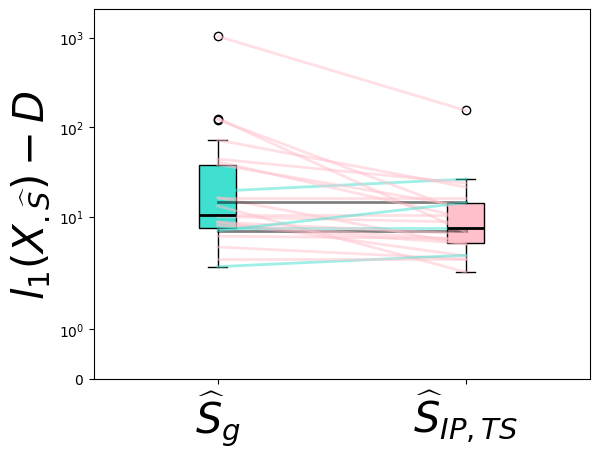

In [471]:
box_plot(iris_df['Losses'],
         iris_df['Two-Stage Losses'],
         D,
         xlabels = [r'$\widehat S_{g}$', r'$\widehat S_{IP,TS}$'],
         ylabel = r'$l_1(X_{.\widehat {S}}) - D$',
         filename = '/Users/samsonkoelle/convexlocalisometry/figures/Figure2b')

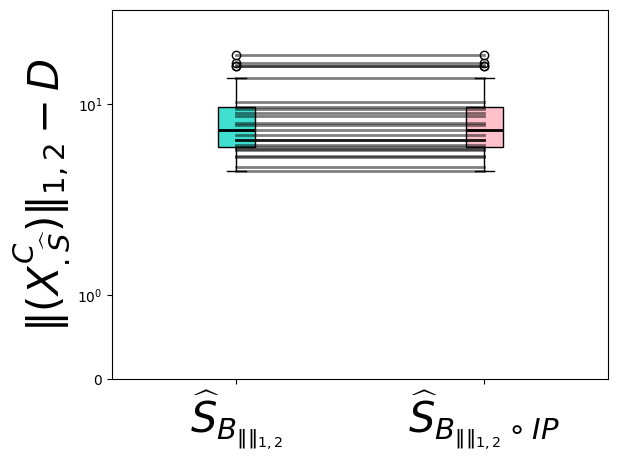

In [472]:
box_plot(iris_df['Brute Losses'],
         iris_df['Greedy Multitask Norms (Two-Stage)'],
         D,
         xlabels = [r'$\widehat S_{B_{\|\|_{1,2}}}$', r'$\widehat S_{B_{\|\|_{1,2}} \circ IP}$'],
         ylabel = r'$\|(X_{.\widehat {S}}^C)\|_{1,2} - D$',
         filename = '/Users/samsonkoelle/convexlocalisometry/figures/FigureS1')

In [ ]:
# okay, what we doing?
# we got 3 datasets - wine, iris, ethanol
# normalized versus unnormalized
# 3 values of C say
# 2 plots each across the 3 C values

# 1 figure is results for 3 datasets normalized

# 3 figures are results for 1 dataset C by normalized versus unnormalized

# 1 figures is for unstandardized group lasso norm ts versus brute across datasets and C values


In [242]:
print("Analyzing standardized wine data")
print("Iris dimension", wine_standardized.shape)
losses = []
support_cardinalities_basis_pursuit = []
two_stage_losses = []
random_two_stage_losses= []
greedy_multitask_norms = []
greedy_multitask_norms_two_stage = []
brute_losses = []
D = D_wine
for i in range(25):
    X = wine_standardized.sample(frac = .1).to_numpy().transpose() # .5
    print("Iris subsampled dimension", X.shape)
    output = greedy(X, isometry_loss_power, D, []) # plainly brute is too hard 178**13 combinations
    loss = isometry_loss_power(X[:,output])
    losses.append(loss)
    
    output = greedy(X, group_lasso_norm, D, []) 
    
    greedy_multitask_norms.append(group_lasso_norm(np.linalg.inv(X[:,output])))
    
    data_transformed = exponential_transformation(X, power = power)
    beta = group_basis_pursuit(data_transformed)
    basis_pursuit_indices = np.where(np.linalg.norm(beta, axis = 1))[0]
    
    support_cardinalities_basis_pursuit.append(len(basis_pursuit_indices))
    
    two_stage_output = basis_pursuit_indices[np.asarray(brute(X[:,basis_pursuit_indices], isometry_loss_power, D))] # plainly this is too hard 178**13 combinations
    two_stage_loss = isometry_loss_power(X[:,two_stage_output])
    two_stage_losses.append(two_stage_loss)
    
    
    two_stage_multitask = basis_pursuit_indices[np.asarray(brute(X[:,basis_pursuit_indices], group_lasso_norm, D))] # plainly this is too hard 178**13 combinations
    greedy_multitask_norms_two_stage.append(group_lasso_norm(np.linalg.inv(X[:,two_stage_multitask])))

    random_indices = np.random.choice(range(X.shape[1]), len(basis_pursuit_indices), replace=False)
    random_two_stage_losses.append(isometry_loss_power(X[:,random_indices]))
    
    brute_solution = brute(X[:,:], group_lasso_norm, D)
    brute_losses.append(group_lasso_norm(np.linalg.inv(X[:,brute_solution])))

    

Analyzing standardized wine data
Iris dimension (178, 13)
Iris subsampled dimension (13, 18)


/Users/samsonkoelle/miniconda3/envs/isometry/lib/python3.10/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 20881.63it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 54929.16it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 50976.35it/s]


Iris subsampled dimension (13, 18)
Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 21983.71it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 57726.55it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 51163.89it/s]


Iris subsampled dimension (13, 18)
Computing brute force solution for dictionary dimension 16 and target_dimension 13


560it [00:00, 17547.68it/s]


Computing brute force solution for dictionary dimension 16 and target_dimension 13


560it [00:00, 49050.04it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 49788.78it/s]


Iris subsampled dimension (13, 18)
Computing brute force solution for dictionary dimension 16 and target_dimension 13


560it [00:00, 18347.36it/s]


Computing brute force solution for dictionary dimension 16 and target_dimension 13


560it [00:00, 46531.36it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 50269.55it/s]


Iris subsampled dimension (13, 18)
Computing brute force solution for dictionary dimension 17 and target_dimension 13


2380it [00:00, 19238.07it/s]


Computing brute force solution for dictionary dimension 17 and target_dimension 13


2380it [00:00, 53381.19it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 50390.22it/s]


Iris subsampled dimension (13, 18)
Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 19731.40it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 50200.66it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 47200.61it/s]


Iris subsampled dimension (13, 18)
Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 19647.55it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 54468.10it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 47215.24it/s]


Iris subsampled dimension (13, 18)
Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 19475.87it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 50841.70it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 47988.48it/s]


Iris subsampled dimension (13, 18)
Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 22068.49it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 51280.55it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 52926.69it/s]


Iris subsampled dimension (13, 18)
Computing brute force solution for dictionary dimension 17 and target_dimension 13


2380it [00:00, 20699.38it/s]


Computing brute force solution for dictionary dimension 17 and target_dimension 13


2380it [00:00, 47828.80it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 52904.87it/s]


Iris subsampled dimension (13, 18)
Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 22439.66it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 56094.54it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 53523.25it/s]


Iris subsampled dimension (13, 18)
Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 22615.51it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 56991.97it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 52768.30it/s]


Iris subsampled dimension (13, 18)
Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 22446.83it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 57020.81it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 53946.52it/s]


Iris subsampled dimension (13, 18)
Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 22450.58it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 56002.92it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 51039.26it/s]


Iris subsampled dimension (13, 18)
Computing brute force solution for dictionary dimension 17 and target_dimension 13


2380it [00:00, 21628.13it/s]


Computing brute force solution for dictionary dimension 17 and target_dimension 13


2380it [00:00, 54563.48it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 51670.52it/s]


Iris subsampled dimension (13, 18)
Computing brute force solution for dictionary dimension 17 and target_dimension 13


2380it [00:00, 19031.14it/s]


Computing brute force solution for dictionary dimension 17 and target_dimension 13


2380it [00:00, 51052.21it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 52024.11it/s]


Iris subsampled dimension (13, 18)
Computing brute force solution for dictionary dimension 16 and target_dimension 13


560it [00:00, 21082.01it/s]


Computing brute force solution for dictionary dimension 16 and target_dimension 13


560it [00:00, 47986.81it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 51196.25it/s]


Iris subsampled dimension (13, 18)
Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 21536.88it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 57502.65it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 51001.89it/s]


Iris subsampled dimension (13, 18)
Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 22612.51it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 56412.24it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 52150.41it/s]


Iris subsampled dimension (13, 18)
Computing brute force solution for dictionary dimension 17 and target_dimension 13


2380it [00:00, 18772.85it/s]


Computing brute force solution for dictionary dimension 17 and target_dimension 13


2380it [00:00, 50633.75it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 52807.38it/s]


Iris subsampled dimension (13, 18)
Computing brute force solution for dictionary dimension 17 and target_dimension 13


2380it [00:00, 19076.60it/s]


Computing brute force solution for dictionary dimension 17 and target_dimension 13


2380it [00:00, 45437.94it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 46330.31it/s]


Iris subsampled dimension (13, 18)
Computing brute force solution for dictionary dimension 17 and target_dimension 13


2380it [00:00, 20116.65it/s]


Computing brute force solution for dictionary dimension 17 and target_dimension 13


2380it [00:00, 52398.80it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 47731.49it/s]


Iris subsampled dimension (13, 18)
Computing brute force solution for dictionary dimension 17 and target_dimension 13


2380it [00:00, 21581.47it/s]


Computing brute force solution for dictionary dimension 17 and target_dimension 13


2380it [00:00, 55132.13it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 53371.82it/s]


Iris subsampled dimension (13, 18)
Computing brute force solution for dictionary dimension 17 and target_dimension 13


2380it [00:00, 20858.73it/s]


Computing brute force solution for dictionary dimension 17 and target_dimension 13


2380it [00:00, 46342.46it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 49530.08it/s]


Iris subsampled dimension (13, 18)
Computing brute force solution for dictionary dimension 17 and target_dimension 13


2380it [00:00, 21455.99it/s]


Computing brute force solution for dictionary dimension 17 and target_dimension 13


2380it [00:00, 52910.10it/s]


Computing brute force solution for dictionary dimension 18 and target_dimension 13


8568it [00:00, 50176.83it/s]


In [ ]:
import matplotlib.pyplot as plt

data = [losses, two_stage_losses]
plt.boxplot(data)
plt.xticks([1, 2], [r'$\widehat S_{g}$', r'$\widehat S_{IP,TS}$'], fontsize=30)
plt.title('Side-by-Side Boxplot')
plt.ylabel('Values')
# plt.ylabel(r'$l_1(X_{.\widehat {S}})$', fontsize = 30)
# plt.savefig('/Users/samsonkoelle/convexlocalisometry/figures/Figure2b')

In [185]:
losses = []
greedy_multitask_losses = []
nbp = []
two_stage_losses = []
random_two_stage_losses= []
D_iris =4
for i in range(25):
    X = iris_standardized.sample(frac = .5).to_numpy().transpose()
#     X = iris_standardized.sample(axis = 1, frac = .5).to_numpy()
# TODO (Sam): enable c in greedy / isometry_loss
    output = greedy(X, isometry_loss_power, D_iris, []) # plainly brute is too hard 178**13 combinations
    loss = isometry_loss_power(X[:,output])
    losses.append(loss)
    data_transformed = exponential_transformation(X, power = power)
#     output = greedy(data_transformed, group_lasso_norm, D_iris, []) # plainly brute is too hard 178**13 combinations    
    
    
    beta = group_basis_pursuit(data_transformed)
    basis_pursuit_indices = np.where(np.linalg.norm(beta, axis = 1))[0]
    nbp.append(len(basis_pursuit_indices))
    #     two_stage_output = basis_pursuit_indices[np.asarray(greedy(X[:,basis_pursuit_indices], isometry_loss, D_wine, []))] # plainly this is too hard 178**13 combinations
    two_stage_output = basis_pursuit_indices[np.asarray(brute(X[:,basis_pursuit_indices], isometry_loss_power, D_iris))] # plainly this is too hard 178**13 combinations
    two_stage_loss = isometry_loss_power(X[:,two_stage_output])
    two_stage_losses.append(two_stage_loss)
    greedy_multitask_losses.append(group_lasso_norm(X[:,two_stage_output]))
    random_indices = np.random.choice(range(X.shape[1]), len(basis_pursuit_indices), replace=False)
    random_two_stage_losses.append(isometry_loss_power(X[:,random_indices]))

/Users/samsonkoelle/miniconda3/envs/isometry/lib/python3.10/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 22184.26it/s]


Computing brute force solution for dictionary dimension 8 and target_dimension 4


70it [00:00, 22544.83it/s]


Computing brute force solution for dictionary dimension 7 and target_dimension 4


35it [00:00, 21913.81it/s]


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 10916.98it/s]


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 16320.25it/s]


Computing brute force solution for dictionary dimension 8 and target_dimension 4


70it [00:00, 20242.78it/s]


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 14367.34it/s]


Computing brute force solution for dictionary dimension 8 and target_dimension 4


70it [00:00, 17262.54it/s]


Computing brute force solution for dictionary dimension 7 and target_dimension 4


35it [00:00, 19555.17it/s]


Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 6210.10it/s]


Computing brute force solution for dictionary dimension 7 and target_dimension 4


35it [00:00, 21352.82it/s]


Computing brute force solution for dictionary dimension 8 and target_dimension 4


70it [00:00, 18642.53it/s]


Computing brute force solution for dictionary dimension 7 and target_dimension 4


35it [00:00, 15433.20it/s]


Computing brute force solution for dictionary dimension 7 and target_dimension 4


35it [00:00, 24224.53it/s]


Computing brute force solution for dictionary dimension 5 and target_dimension 4


5it [00:00, 18063.32it/s]


Computing brute force solution for dictionary dimension 9 and target_dimension 4


126it [00:00, 24155.88it/s]


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 15446.74it/s]


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 20164.92it/s]


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 16990.16it/s]


Computing brute force solution for dictionary dimension 7 and target_dimension 4


35it [00:00, 17499.18it/s]


Computing brute force solution for dictionary dimension 8 and target_dimension 4


70it [00:00, 26090.93it/s]


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 21305.30it/s]


Computing brute force solution for dictionary dimension 7 and target_dimension 4


35it [00:00, 16973.13it/s]


Computing brute force solution for dictionary dimension 6 and target_dimension 4


15it [00:00, 21868.11it/s]


Computing brute force solution for dictionary dimension 7 and target_dimension 4


35it [00:00, 21550.30it/s]


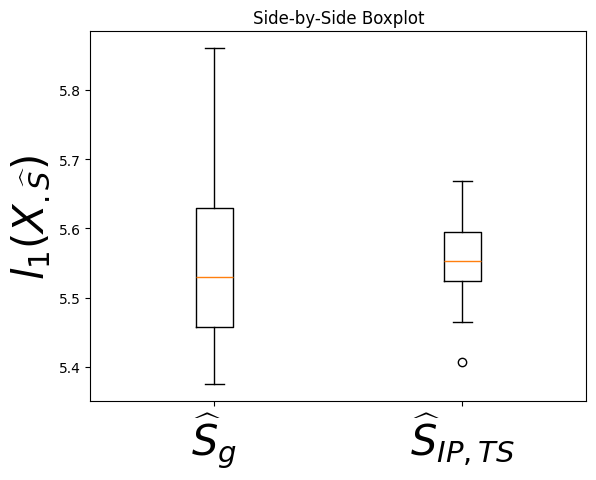

In [107]:
import matplotlib.pyplot as plt

data = [losses, two_stage_losses]
plt.boxplot(data)
plt.xticks([1, 2], [r'$\widehat S_{g}$', r'$\widehat S_{IP,TS}$'], fontsize=30)
plt.title('Side-by-Side Boxplot')
plt.ylabel('Values')
plt.ylabel(r'$l_1(X_{.\widehat {S}})$', fontsize = 30)
plt.savefig('/Users/samsonkoelle/convexlocalisometry/figures/Figure2b')

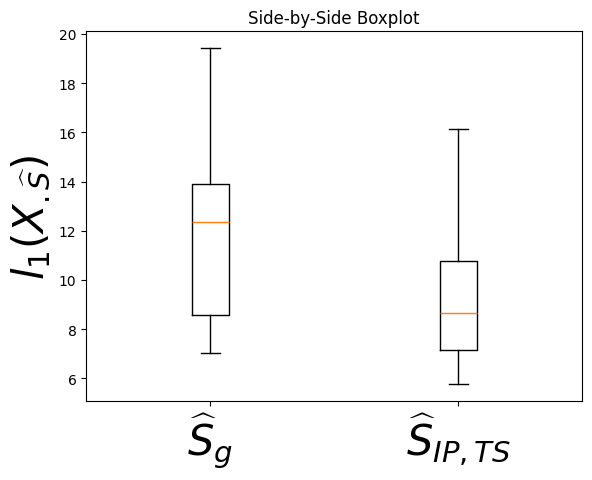

In [65]:
import matplotlib.pyplot as plt

data = [losses, two_stage_losses]
plt.boxplot(data)
plt.xticks([1, 2], [r'$\widehat S_{g}$', r'$\widehat S_{IP,TS}$'], fontsize=30)
plt.title('Side-by-Side Boxplot')
plt.ylabel('Values')
plt.ylabel(r'$l_1(X_{.\widehat {S}})$', fontsize = 30)
plt.savefig('/Users/samsonkoelle/convexlocalisometry/figures/Figure2b')

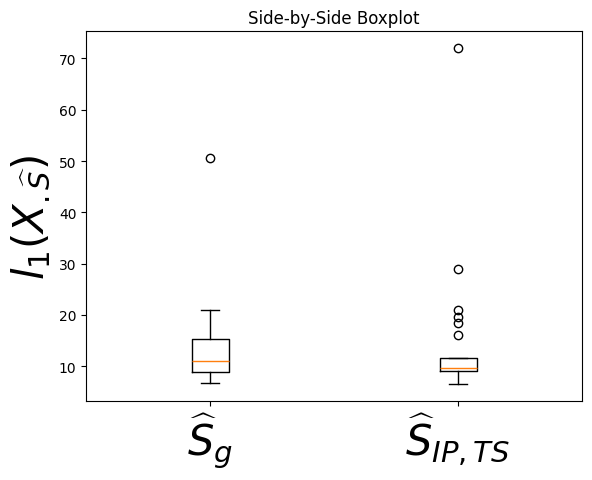

In [67]:
import matplotlib.pyplot as plt

data = [losses, two_stage_losses]
plt.boxplot(data)
plt.xticks([1, 2], [r'$\widehat S_{g}$', r'$\widehat S_{IP,TS}$'], fontsize=30)
plt.title('Side-by-Side Boxplot')
plt.ylabel('Values')
plt.ylabel(r'$l_1(X_{.\widehat {S}})$', fontsize = 30)
plt.savefig('/Users/samsonkoelle/convexlocalisometry/figures/Figure2b')

In [108]:
losses = []
two_stage_losses = []
nbp = []
random_two_stage_losses= []
dimension = 6
for i in range(25):
    X = wine_standardized.sample(frac = .5).to_numpy().transpose()[:dimension,:]
    output = greedy(X, isometry_loss, dimension, []) # plainly brute is too hard 178**13 combinations
#     output = brute(X, isometry_loss, dimension)
    loss = isometry_loss(X[:,output])
    losses.append(loss)
    data_transformed = exponential_transformation(X)
    beta = group_basis_pursuit(data_transformed)
    basis_pursuit_indices = np.where(np.linalg.norm(beta, axis = 1))[0]
    nbp.append(len(basis_pursuit_indices))

    two_stage_output = basis_pursuit_indices[np.asarray(brute(X[:,basis_pursuit_indices], isometry_loss, dimension))] # plainly this is too hard 178**13 combinations
    two_stage_loss = isometry_loss(X[:,two_stage_output])
    two_stage_losses.append(two_stage_loss)
    random_indices = np.random.choice(range(X.shape[1]), len(basis_pursuit_indices), replace=False)
    random_two_stage_losses.append(isometry_loss(X[:,random_indices]))

/Users/samsonkoelle/convexlocalisometry/convexlocalisometry/loss.py:14: RuntimeWarning: overflow encountered in exp
  (np.exp(singular_values) + np.exp(singular_values ** (-1))) / (2 * np.e)
/Users/samsonkoelle/miniconda3/envs/isometry/lib/python3.10/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Computing brute force solution for dictionary dimension 16 and target_dimension 6


8008it [00:00, 25575.41it/s]


Computing brute force solution for dictionary dimension 14 and target_dimension 6


3003it [00:00, 25010.17it/s]


Computing brute force solution for dictionary dimension 14 and target_dimension 6


3003it [00:00, 26647.15it/s]


Computing brute force solution for dictionary dimension 16 and target_dimension 6


8008it [00:00, 28273.74it/s]


Computing brute force solution for dictionary dimension 14 and target_dimension 6


3003it [00:00, 27329.76it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 6


5005it [00:00, 28233.44it/s]


Computing brute force solution for dictionary dimension 14 and target_dimension 6


3003it [00:00, 24943.75it/s]


Computing brute force solution for dictionary dimension 16 and target_dimension 6


8008it [00:00, 28037.82it/s]


Computing brute force solution for dictionary dimension 15 and target_dimension 6


5005it [00:00, 27373.96it/s]


Computing brute force solution for dictionary dimension 16 and target_dimension 6


8008it [00:00, 28663.88it/s]


Computing brute force solution for dictionary dimension 11 and target_dimension 6


462it [00:00, 25412.69it/s]


Computing brute force solution for dictionary dimension 12 and target_dimension 6


924it [00:00, 24537.88it/s]


Computing brute force solution for dictionary dimension 16 and target_dimension 6


8008it [00:00, 28848.40it/s]


Computing brute force solution for dictionary dimension 13 and target_dimension 6


1716it [00:00, 27664.96it/s]


Computing brute force solution for dictionary dimension 16 and target_dimension 6


8008it [00:00, 27724.48it/s]


Computing brute force solution for dictionary dimension 12 and target_dimension 6


924it [00:00, 26225.40it/s]


Computing brute force solution for dictionary dimension 14 and target_dimension 6


3003it [00:00, 26005.43it/s]


Computing brute force solution for dictionary dimension 14 and target_dimension 6


3003it [00:00, 26490.34it/s]


Computing brute force solution for dictionary dimension 17 and target_dimension 6


12376it [00:00, 28938.86it/s]


Computing brute force solution for dictionary dimension 14 and target_dimension 6


3003it [00:00, 25231.66it/s]


Computing brute force solution for dictionary dimension 17 and target_dimension 6


12376it [00:00, 26509.69it/s]


Computing brute force solution for dictionary dimension 14 and target_dimension 6


3003it [00:00, 25806.95it/s]


Computing brute force solution for dictionary dimension 14 and target_dimension 6


3003it [00:00, 23966.31it/s]


Computing brute force solution for dictionary dimension 13 and target_dimension 6


1716it [00:00, 27196.63it/s]


Computing brute force solution for dictionary dimension 12 and target_dimension 6


924it [00:00, 25533.41it/s]


In [110]:
??greedy

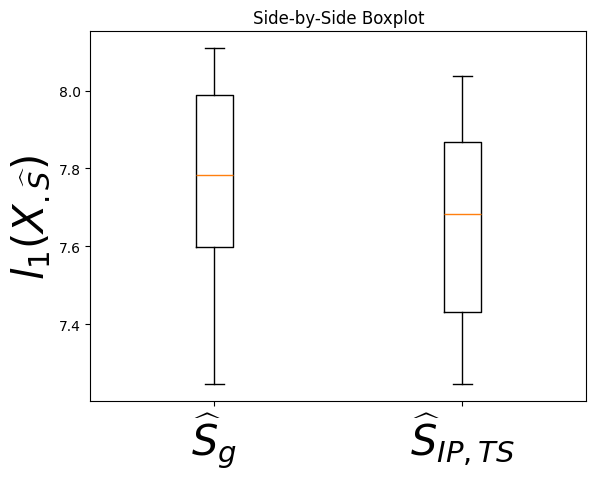

In [109]:
import matplotlib.pyplot as plt

data = [losses, two_stage_losses]
plt.boxplot(data)
plt.xticks([1, 2], [r'$\widehat S_{g}$', r'$\widehat S_{IP,TS}$'], fontsize=30)
plt.title('Side-by-Side Boxplot')
plt.ylabel('Values')
plt.ylabel(r'$l_1(X_{.\widehat {S}})$', fontsize = 30)
plt.savefig('/Users/samsonkoelle/convexlocalisometry/figures/Figure2b')

In [8]:
print(np.mean(losses))
print(np.std(losses))  # Standard deviation
print(np.mean(two_stage_losses))
print(np.std(two_stage_losses))  # Standard deviation
print(np.mean(nbp))
print(np.std(nbp))  # Standard deviation

5.734369034010522
0.18991729870508334
5.618834928412273
0.12878299514658612
11.48
1.389100428334827


In [128]:
def greedy(matrix, loss, target_dimension=None, selected_indices=[]):
    """Matrix is d \times p dimensional"""
    if target_dimension is None:
        target_dimension, dictionary_dimension = (
            matrix.shape
        )  # NOTE (Sam): this won't hold necessarily for regression in ambient space instead of tangent space.
    else:
        dictionary_dimension = matrix.shape[1]

    while len(selected_indices) < target_dimension:
        # if target_dimension > 0:
        candidate_losses = np.repeat(np.nan, dictionary_dimension)
        dictionary_indices = list(range(dictionary_dimension))
        random.shuffle(dictionary_indices)
        print(dictionary_indices)
        for p in dictionary_indices:
            if p not in selected_indices:
                candidate_parametrization = np.concatenate(
                    [selected_indices, [p]]
                ).astype(int)
                candidate_losses[p] = loss(matrix[:, candidate_parametrization])
        most_isometric_index = np.nanargmin(candidate_losses)
        selected_indices.append(most_isometric_index)
        selected_indices = greedy(
            matrix, loss, target_dimension, selected_indices=selected_indices
        )

    return selected_indices

In [136]:
losses = []
X = wine_standardized.sample(frac = .5).to_numpy().transpose()[:dimension,:]
for a in range(25):
    output = greedy(X, isometry_loss, dimension, []) # plainly brute is too hard 178**13 combinations
    print(output)
    loss = isometry_loss(X[:,output])
    losses.append(loss)

[63, 28, 27, 25, 11, 37, 66, 59, 29, 72, 62, 71, 84, 53, 78, 67, 32, 10, 36, 44, 20, 22, 70, 13, 9, 8, 55, 69, 6, 31, 43, 3, 73, 15, 85, 0, 41, 45, 52, 5, 23, 57, 40, 76, 81, 12, 18, 61, 26, 54, 7, 4, 56, 2, 1, 58, 24, 16, 50, 87, 86, 88, 49, 38, 33, 75, 74, 34, 47, 35, 39, 82, 64, 68, 30, 21, 46, 14, 79, 42, 60, 77, 48, 65, 17, 80, 19, 83, 51]
[37, 32, 20, 22, 29, 40, 0, 82, 55, 70, 63, 11, 30, 52, 13, 2, 66, 69, 1, 64, 10, 43, 59, 81, 49, 27, 61, 62, 78, 26, 60, 35, 33, 45, 56, 47, 28, 54, 36, 77, 83, 67, 44, 73, 15, 72, 75, 53, 68, 51, 21, 12, 65, 76, 24, 34, 3, 87, 16, 80, 31, 46, 18, 86, 57, 38, 79, 41, 9, 84, 25, 14, 50, 74, 17, 4, 85, 23, 58, 6, 5, 8, 71, 88, 42, 19, 39, 7, 48]
[27, 44, 64, 32, 35, 87, 81, 17, 24, 39, 48, 11, 55, 23, 0, 80, 34, 75, 1, 40, 45, 4, 60, 56, 78, 22, 43, 28, 33, 41, 18, 88, 82, 30, 46, 29, 74, 69, 58, 21, 36, 2, 65, 10, 51, 25, 63, 70, 9, 49, 38, 13, 86, 85, 42, 84, 83, 3, 7, 8, 16, 71, 67, 76, 73, 66, 57, 54, 15, 31, 79, 37, 50, 72, 61, 19, 77, 26, 1

[55, 18, 25, 11, 37, 43, 67, 22, 9, 78, 24, 36, 1, 85, 69, 68, 62, 57, 65, 81, 52, 26, 53, 13, 50, 6, 30, 77, 84, 40, 20, 58, 23, 32, 5, 61, 73, 66, 31, 48, 75, 41, 79, 83, 46, 80, 33, 16, 17, 70, 10, 34, 59, 8, 42, 14, 7, 21, 39, 56, 45, 12, 60, 63, 47, 44, 74, 3, 15, 54, 2, 86, 35, 28, 4, 51, 82, 0, 88, 72, 64, 71, 87, 27, 76, 38, 49, 29, 19]
[33, 35, 20, 46, 54, 87, 62, 37, 11, 45, 14, 50, 84, 42, 3, 47, 4, 19, 36, 31, 25, 24, 22, 0, 48, 21, 58, 79, 88, 28, 41, 40, 75, 43, 76, 12, 18, 57, 65, 29, 85, 51, 53, 70, 23, 74, 1, 44, 27, 13, 9, 49, 86, 15, 69, 16, 77, 63, 26, 78, 32, 72, 83, 60, 5, 39, 10, 73, 59, 17, 30, 34, 81, 66, 38, 8, 80, 52, 64, 71, 7, 82, 2, 56, 6, 61, 55, 68, 67]
[31, 59, 86, 33, 73, 74, 77, 11, 18, 65, 68, 25, 16, 13, 32, 53, 78, 35, 55, 85, 63, 87, 12, 47, 49, 44, 58, 19, 15, 52, 4, 28, 66, 27, 37, 34, 10, 62, 46, 54, 17, 80, 41, 5, 9, 70, 38, 57, 67, 48, 0, 21, 3, 71, 40, 7, 6, 36, 84, 14, 56, 76, 43, 83, 39, 45, 79, 26, 23, 8, 61, 69, 2, 20, 82, 24, 51, 72, 29

[32, 75, 80, 67, 54, 60]
